In [58]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [59]:
picks = pd.read_csv('picks.csv')

In this notebook we will be dealing with the picks dataset. 

This dataset has information about every match's pick/ban phase and so we can extract insights like what maps are most picked in what timeframe, which maps are removed the most, and a teams preferred map pick/ban in any given time period.

# Data Cleaning 

In [60]:
picks.head()

,date,team_1,team_2,inverted_teams,match_id,event_id,best_of,system,t1_removed_1,t1_removed_2,t1_removed_3,t2_removed_1,t2_removed_2,t2_removed_3,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,1,2340454,5151,3,123412,Vertigo,Train,0.0,Nuke,Overpass,0.0,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,0,2340453,5151,3,123412,Dust2,Nuke,0.0,Mirage,Train,0.0,Vertigo,Inferno,Overpass
2,2020-03-18,New England Whalers,Station7,0,2340461,5243,1,121212,Mirage,Dust2,Vertigo,Nuke,Train,Overpass,0.0,0.0,Inferno
3,2020-03-17,Complexity,forZe,1,2340279,5226,3,123412,Inferno,Nuke,0.0,Overpass,Vertigo,0.0,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,0,2340456,5247,3,123412,Train,Mirage,0.0,Nuke,Inferno,0.0,Overpass,Vertigo,Dust2


In [61]:
picks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16035 entries, 0 to 16034
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            16035 non-null  object
 1   team_1          16035 non-null  object
 2   team_2          16035 non-null  object
 3   inverted_teams  16035 non-null  int64 
 4   match_id        16035 non-null  int64 
 5   event_id        16035 non-null  int64 
 6   best_of         16035 non-null  object
 7   system          16035 non-null  int64 
 8   t1_removed_1    16035 non-null  object
 9   t1_removed_2    16035 non-null  object
 10  t1_removed_3    16035 non-null  object
 11  t2_removed_1    16035 non-null  object
 12  t2_removed_2    16035 non-null  object
 13  t2_removed_3    16035 non-null  object
 14  t1_picked_1     16035 non-null  object
 15  t2_picked_1     16035 non-null  object
 16  left_over       16035 non-null  object
dtypes: int64(4), object(13)
memory usage: 2.1+ MB


Check for missing data in the dataframe

<AxesSubplot:>

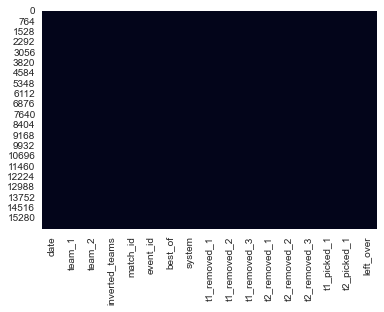

In [62]:
sns.heatmap(picks.isnull(), cbar=False)

This heatmap may be misleading. We may think that the data is clean since there are no null values, but the values in the columns may not be perfect, which we will see later on in this notebook.

In [63]:
picks['date'] = pd.to_datetime(picks['date'])

In [64]:
picks['best_of'].value_counts()

3            10142
1             5656
2              224
3(LAN)           3
of               3
3.               3
1(Online)        2
3(Online)        1
2(Online)        1
Name: best_of, dtype: int64

I only want to consider best of 3 matches as it will streamline the analysis and it is the most common type match-type in big tournaments (aside from best of 5 matches in grand finals).

In [65]:
picks.at[picks['best_of'] ==  '3.', 'best_of'] = '3'
picks.at[picks['best_of'] ==  'of', 'best_of'] = '3'
picks.at[picks['best_of'] ==  '3(LAN)', 'best_of'] = '3'
picks.at[picks['best_of'] ==  '3(Online)', 'best_of'] = '3'

picks = picks[picks['best_of'] == '3']

We can drop some columns that we will not need since we are only considering best of 3s.

In [66]:
picks.drop(['best_of', 't1_removed_3', 't2_removed_3', 'inverted_teams', 'system'], axis=1, inplace=True)

To make sure the other columns only have the values we want, we set a list of those values for the map related columns. 

In [67]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
columns = ['t1_removed_1', 't1_removed_2', 't2_removed_1', 't2_removed_2', 't1_picked_1', 't2_picked_1', 'left_over']

for c in columns:
    picks.drop(picks[~picks[c].isin(maps)].index, inplace=True)

In [68]:
picks.head()

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,2340454,5151,Vertigo,Train,Nuke,Overpass,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,2340453,5151,Dust2,Nuke,Mirage,Train,Vertigo,Inferno,Overpass
3,2020-03-17,Complexity,forZe,2340279,5226,Inferno,Nuke,Overpass,Vertigo,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,2340456,5247,Train,Mirage,Nuke,Inferno,Overpass,Vertigo,Dust2
5,2020-03-17,BIG,fnatic,2340397,5226,Train,Dust2,Nuke,Vertigo,Inferno,Overpass,Mirage


match_id and event_id have information that can be used to join this data do the other datasets. You can find my analysis on those in the other notebooks in this repository.

# Data Visualizations

To start off we will make some preliminary visualizations to see how the data looks and then we will answer some specific questions.

### Note that even there there are 9 maps listed here, competitive CS:GO's map pool is set at 7 at a given time. Cache and Cobblestone were replaced with Nuke and Vertigo at seperate times.

### In a best of 3 match the map pick/veto system is as follows: <br> <br> Team 1 Veto, <br> Team 2 Veto, <br> <br> Team 1 Pick, <br> Team 2 Pick, <br> <br> Team 1 Veto, <br> Team 2 Veto, <br> <br> Final Map Left Over 



The map pick/veto system is not consistently in this order, however it is the common system used.

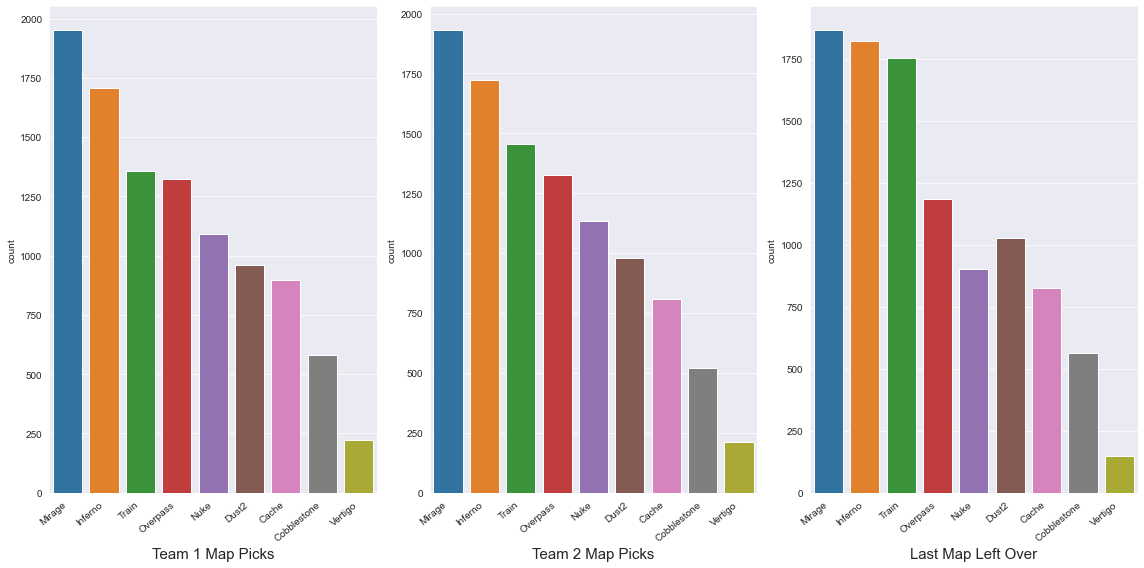

In [76]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
sns.set_style('darkgrid')
f, ax = plt.subplots(1,3,figsize=(16,8))

sns.countplot(x='t1_picked_1', data=picks, ax=ax[0], order=maps)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_xlabel('Team 1 Map Picks', fontsize=15)

sns.countplot(x='t2_picked_1', data=picks, ax=ax[1], order=maps)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_xlabel('Team 2 Map Picks', fontsize=15)

sns.countplot(x='left_over', data=picks, ax=ax[2], order=maps)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=40, ha="right")
ax[2].set_xlabel('Last Map Left Over', fontsize=15)
plt.tight_layout()

The two different sides a team can be on has no effect on what map is picked and the left over map has only a slight difference where Dust2 and Nuke are switched

Now to look at the map bans and see the frequency of the maps that have been banned in the 1st and 2nd rotations

In [77]:
print(picks['t1_removed_1'].value_counts())
print('')
print(picks['t1_removed_2'].value_counts())

Nuke           2193
Overpass       1566
Train          1275
Cache          1058
Inferno         895
Dust2           889
Vertigo         848
Mirage          833
Cobblestone     535
Name: t1_removed_1, dtype: int64

Overpass       1603
Train          1529
Nuke           1335
Mirage         1209
Inferno        1197
Dust2          1144
Cache          1075
Cobblestone     508
Vertigo         492
Name: t1_removed_2, dtype: int64


In [78]:
print(picks['t2_removed_1'].value_counts())
print('')
print(picks['t2_removed_2'].value_counts())

Nuke           2182
Overpass       1548
Train          1221
Cache          1211
Dust2           875
Mirage          864
Vertigo         817
Inferno         806
Cobblestone     568
Name: t2_removed_1, dtype: int64

Overpass       1540
Train          1503
Mirage         1431
Nuke           1242
Inferno        1230
Dust2          1108
Cache          1026
Cobblestone     563
Vertigo         449
Name: t2_removed_2, dtype: int64


In [79]:
picks = picks.drop(picks[picks['t1_removed_2'] == '0.0'].index)
picks = picks.drop(picks[picks['t2_removed_1'] == '0.0'].index)
picks = picks.drop(picks[picks['t2_removed_2'] == '0.0'].index)

[Text(0, 0, 'First Veto'), Text(1, 0, 'Second Veto')]

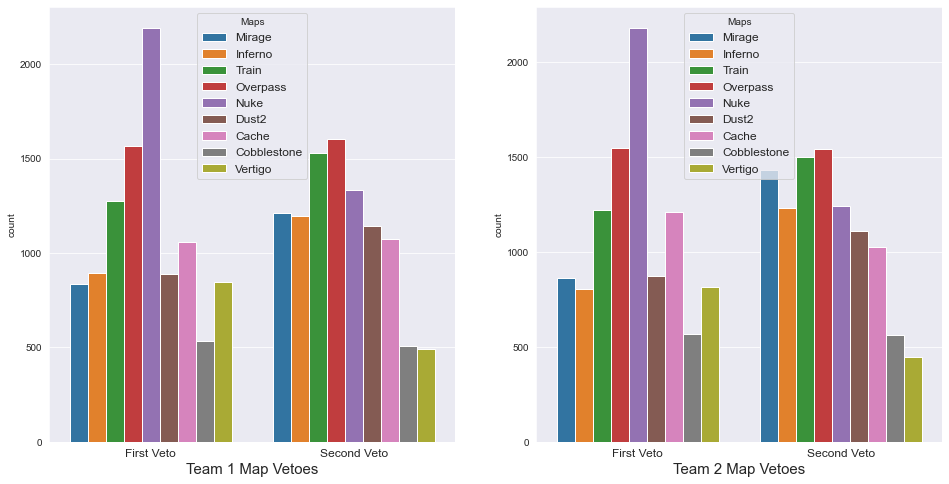

In [80]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
f, ax = plt.subplots(1,2,figsize=(16,8))
melt_df_1 = picks[['t1_removed_1', 't1_removed_2']]
melt_df_2 = picks[['t2_removed_1', 't2_removed_2']]

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_1), ax=ax[0], hue_order=maps)
ax[0].set_xlabel('Team 1 Map Vetoes', fontsize=15)
ax[0].legend(title='Maps', fontsize=12)
ax[0].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_2), ax=ax[1], hue_order=maps)
ax[1].set_xlabel('Team 2 Map Vetoes', fontsize=15)
ax[1].legend(loc='upper center', title='Maps', fontsize=12)
ax[1].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)

From this plot we can see that in each rotation of the vetoes both teams have very similar picks and that the maps vetoed in each stage do differ, which may have to do with what maps were vetoed 
and picked in the first rotations of vetoes and picks.

In [81]:
picks.head()

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,2340454,5151,Vertigo,Train,Nuke,Overpass,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,2340453,5151,Dust2,Nuke,Mirage,Train,Vertigo,Inferno,Overpass
3,2020-03-17,Complexity,forZe,2340279,5226,Inferno,Nuke,Overpass,Vertigo,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,2340456,5247,Train,Mirage,Nuke,Inferno,Overpass,Vertigo,Dust2
5,2020-03-17,BIG,fnatic,2340397,5226,Train,Dust2,Nuke,Vertigo,Inferno,Overpass,Mirage


In [82]:
picks[picks['t1_removed_1'] == 'Nuke']

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
11,2020-03-17,HellRaisers,AGO,2340449,5150,Nuke,Mirage,Overpass,Dust2,Inferno,Train,Vertigo
39,2020-03-15,Incept,I sleep,2340436,5248,Nuke,Overpass,Train,Mirage,Dust2,Vertigo,Inferno
40,2020-03-15,Endpoint,Tricked,2340329,5247,Nuke,Inferno,Vertigo,Overpass,Dust2,Train,Mirage
43,2020-03-14,Paradox,ORDER,2340282,5236,Nuke,Train,Overpass,Dust2,Inferno,Vertigo,Mirage
51,2020-03-14,Envy,Gen.G,2340339,5242,Nuke,Vertigo,Overpass,Dust2,Train,Inferno,Mirage
...,...,...,...,...,...,...,...,...,...,...,...,...
15981,2016-08-11,Complexity,Blight,2303836,2364,Nuke,Dust2,Mirage,Cobblestone,Cache,Overpass,Train
15983,2016-08-10,MK,Spirit,2303826,2329,Nuke,Cobblestone,Train,Overpass,Dust2,Mirage,Cache
15988,2016-08-09,GODSENT,X,2303858,2329,Nuke,Overpass,Cache,Mirage,Train,Dust2,Cobblestone
15998,2016-07-27,Exile5,GUTS,2303537,2301,Nuke,Overpass,Cobblestone,Cache,Train,Dust2,Mirage


Some takeaways from these visualizations:
- Mirage and Inferno are the most played maps and most popular map picks from 2016-2020, with Train and Overpass close behind.
- Nuke is by far the most popular first rotation map veto for either team. 
- Dust2, Cache, Cobblestone, and Vertigo underperform in map picks/vetoes since they were not consistently included in the map pools of the tournaments that ran from 2016-2020.
- In the case of Vertigo, which was only added in 2019, we will look closer to the matches played from its introduction to where the data ends.

In [83]:
# Find the first date which Vertigo appears as a map veto, pick, or left over
picks[picks.isin(['Vertigo']).any(axis=1)]['date'].tail(1)

4712   2019-04-02
Name: date, dtype: datetime64[ns]

In [84]:
vertigo_df = picks[picks['date'] >= '2019-04-02']

In [85]:
vertigo_df.head()

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,2340454,5151,Vertigo,Train,Nuke,Overpass,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,2340453,5151,Dust2,Nuke,Mirage,Train,Vertigo,Inferno,Overpass
3,2020-03-17,Complexity,forZe,2340279,5226,Inferno,Nuke,Overpass,Vertigo,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,2340456,5247,Train,Mirage,Nuke,Inferno,Overpass,Vertigo,Dust2
5,2020-03-17,BIG,fnatic,2340397,5226,Train,Dust2,Nuke,Vertigo,Inferno,Overpass,Mirage


In [86]:
vertigo_df[vertigo_df.isin(['Cobblestone']).any(axis=1)]

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over


Cobblestone has stopped being played at this point so we can remove it from the maps considered in the visualizations

In [87]:
vertigo_df['t1_picked_1'].value_counts()

Inferno     633
Mirage      602
Nuke        533
Dust2       513
Overpass    492
Train       448
Vertigo     224
Cache        17
Name: t1_picked_1, dtype: int64

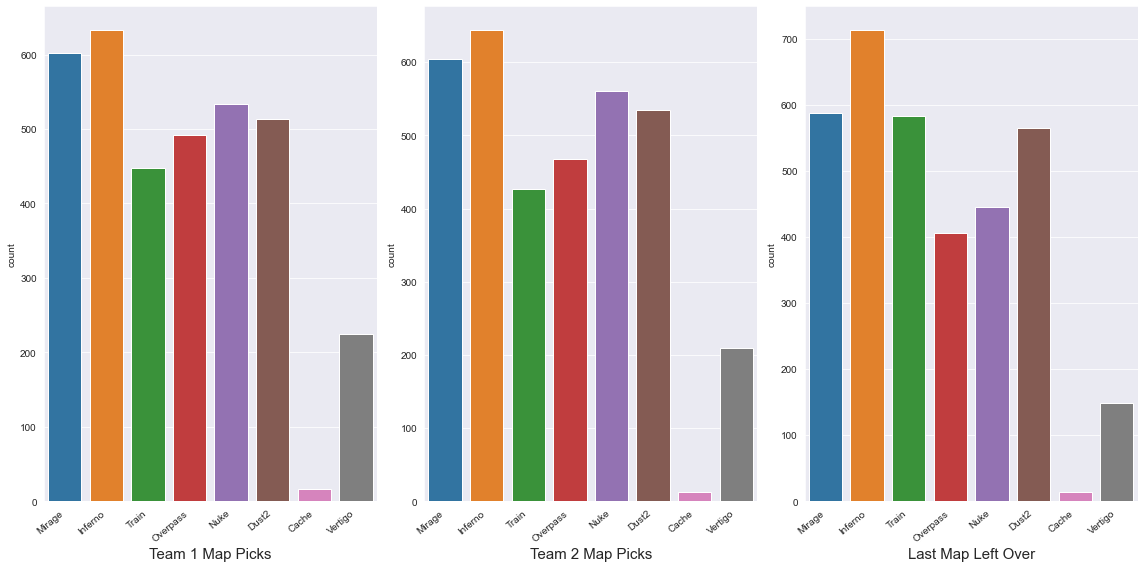

In [88]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Vertigo']
f, ax = plt.subplots(1,3,figsize=(16,8))

sns.countplot(x='t1_picked_1', data=vertigo_df, ax=ax[0], order=maps)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_xlabel('Team 1 Map Picks', fontsize=15)

sns.countplot(x='t2_picked_1', data=vertigo_df, ax=ax[1], order=maps)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_xlabel('Team 2 Map Picks', fontsize=15)

sns.countplot(x='left_over', data=vertigo_df, ax=ax[2], order=maps)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=40, ha="right")
ax[2].set_xlabel('Last Map Left Over', fontsize=15)
plt.tight_layout()

[Text(0, 0, 'First Veto'), Text(1, 0, 'Second Veto')]

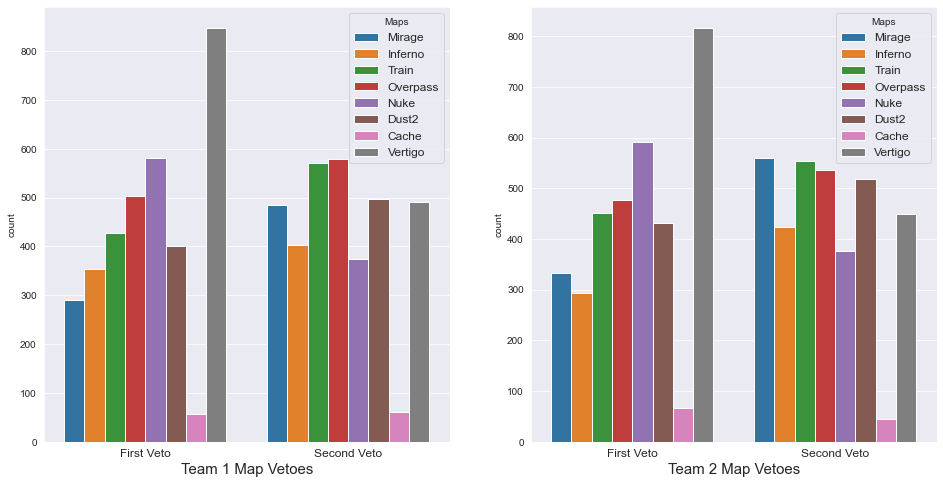

In [89]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Vertigo']
f, ax = plt.subplots(1,2,figsize=(16,8))
melt_df_1 = vertigo_df[['t1_removed_1', 't1_removed_2']]
melt_df_2 = vertigo_df[['t2_removed_1', 't2_removed_2']]

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_1), ax=ax[0], hue_order=maps)
ax[0].set_xlabel('Team 1 Map Vetoes', fontsize=15)
ax[0].legend(title='Maps', fontsize=12)
ax[0].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_2), ax=ax[1], hue_order=maps)
ax[1].set_xlabel('Team 2 Map Vetoes', fontsize=15)
ax[1].legend(title='Maps', fontsize=12)
ax[1].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)

Once we only look at data once Vertigo is introduced the tendancies of map vetoes changes and Vertigo becomes the most popular map veto, while Nuke is still second most popular.

In [90]:
picks_2016 = picks[picks['date'].dt.year == 2016]
picks_2017 = picks[picks['date'].dt.year == 2017]
picks_2018 = picks[picks['date'].dt.year == 2018]
picks_2019 = picks[picks['date'].dt.year == 2019]
picks_2020 = picks[picks['date'].dt.year == 2020]

In [91]:
dict_2016 = dict(picks_2016['t1_picked_1'].value_counts())
dict_2017 = dict(picks_2017['t1_picked_1'].value_counts())
dict_2018 = dict(picks_2018['t1_picked_1'].value_counts())
dict_2019 = dict(picks_2019['t1_picked_1'].value_counts())
dict_2020 = dict(picks_2020['t1_picked_1'].value_counts())

In [92]:
dict(picks_2017['t1_picked_1'].value_counts())

{'Mirage': 460,
 'Inferno': 344,
 'Train': 338,
 'Cobblestone': 335,
 'Cache': 332,
 'Overpass': 284,
 'Nuke': 181,
 'Dust2': 16}

In [93]:
pd.DataFrame([dict_2016, dict_2017, dict_2018, dict_2019, dict_2020], columns=maps, index=[2016, 2017, 2018, 2019, 2020])

,Mirage,Inferno,Train,Overpass,Nuke,Dust2,Cache,Vertigo
2016,107,2,86,54,47,91,95.0,NaN
2017,460,344,338,284,181,16,332.0,NaN
2018,672,613,409,409,262,246,391.0,NaN
2019,620,644,440,507,519,514,78.0,171.0
2020,95,104,83,70,81,92,NaN,53.0


In [94]:
def plot_maps(date_range=None, column='t1_picked_1'):
    """ Plot column frequency by a date range. Default will be team 1 map picks with the full dataset.
    """
    assert column in ['t1_removed_1', 't1_removed_2', 't2_removed_1', 't2_removed_2', 't1_picked_1', 't2_picked_2', 'left_over']
    new_df = pd.DataFrame(None, columns=['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo'])
    if date_range is None:
        for index, row in picks.sort_values(by='date',ascending=True).iterrows():
            map_pick = row[column]
            date = row['date']
            if math.isnan(new_df[map_pick].max()):
                new_df.loc[date, map_pick] = 1
            else:
                new_df.loc[date, map_pick] = new_df[map_pick].max() + 1
    else:
        df = picks[(picks['date'] > date_range[0]) & (picks['date'] < date_range[1])].sort_values(by='date',ascending=True)
        for index, row in df.sort_values(by='date',ascending=True).iterrows():
            map_pick = row[column]
            date = row['date']
            if math.isnan(new_df[map_pick].max()):
                new_df.loc[date, map_pick] = 1
            else:
                new_df.loc[date, map_pick] = new_df[map_pick].max() + 1
    return new_df

In [95]:
df = plot_maps()

NameError: name 'math' is not defined

<AxesSubplot:>

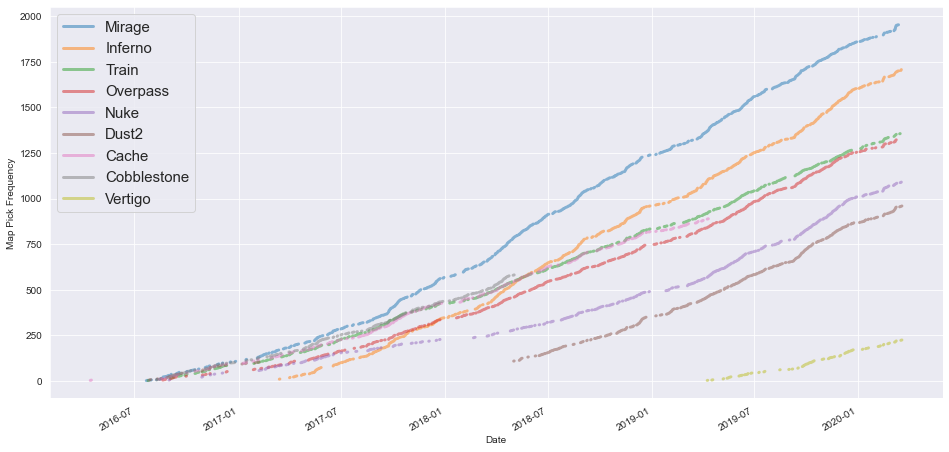

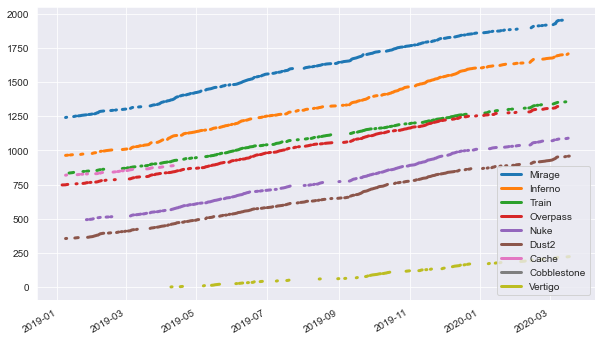

In [ ]:
df.plot(figsize=(16,8), lw=3, ylabel= 'Map Pick Frequency', xlabel='Date', fontsize=10, alpha=0.5)
plt.legend(prop={'size': 15})

df.loc['2019':].plot(figsize=(10,6), lw=3)

In [ ]:
picks[picks['t1_removed_1'] == 'Vertigo'].sort_values(by='date', ascending=True)

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
4706,2019-04-02,x-kom,Tricked,2332184,4513,Vertigo,Overpass,Inferno,Mirage,Nuke,Train,Dust2
4630,2019-04-08,ALTERNATE aTTaX,Tricked,2332324,4513,Vertigo,Dust2,Overpass,Train,Inferno,Nuke,Mirage
4610,2019-04-09,WePlayGames,Imperial,2332219,4520,Vertigo,Nuke,Overpass,Mirage,Inferno,Train,Dust2
4625,2019-04-09,Windigo,Unique,2332433,4433,Vertigo,Inferno,Overpass,Nuke,Dust2,Mirage,Train
4588,2019-04-10,Windigo,Epsilon,2332441,4513,Vertigo,Train,Overpass,Dust2,Nuke,Mirage,Inferno
...,...,...,...,...,...,...,...,...,...,...,...,...
52,2020-03-14,Imperial,Reapers,2340431,5245,Vertigo,Nuke,Overpass,Dust2,Train,Mirage,Inferno
37,2020-03-15,Orgless,Dignitas,2340338,5242,Vertigo,Dust2,Mirage,Overpass,Train,Nuke,Inferno
14,2020-03-17,Japaleno,pro100,2340448,5150,Vertigo,Mirage,Nuke,Overpass,Inferno,Dust2,Train
10,2020-03-17,Espada,Tricked,2340455,5247,Vertigo,Inferno,Overpass,Mirage,Dust2,Nuke,Train


In [ ]:
picks[picks['t1_removed_1'] == 'Vertigo'].first_valid_index()

0

In [ ]:
picks.loc[4706, 'date']

Timestamp('2019-04-02 00:00:00')

In [ ]:
picks.loc[0, 'date']

Timestamp('2020-03-18 00:00:00')

In [ ]:
df2 = plot_maps(date_range=['2019-04-02', '2020-03-18'], column='t1_removed_1')

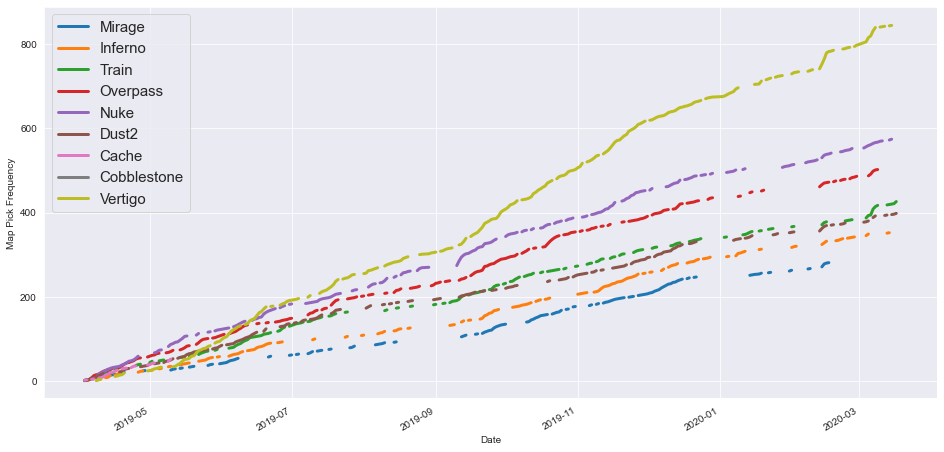

In [ ]:
df2.plot(figsize=(16,8), lw=3, ylabel= 'Map Pick Frequency', xlabel='Date', fontsize=10)
plt.legend(prop={'size': 15})

Final takeaways from the picks dataset:
- In 2019 and 2020 Vertigo dominates the first map veto, this is because it was a new map introduced into the map pool and teams generally did not want to play on it.
- Note that the data from 2020 is only up until March, otherwise the bulk of the games played were between 2017 and the end of the dataset March 2020.
- Mirage and Inferno seem to be the most favoured maps that the teams want to play on.